In [ ]:
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")
ipython = get_ipython()
ipython.magic("sx wget https://www.dropbox.com/s/80yl6pxjx7usk4p/ISB_PyTorch_Tutorial.zip") 
!unzip -q ISB_PyTorch_Tutorial.zip
!mv ISB_PyTorch_Tutorial/* .


In [ ]:
import torch
import random
import numpy as np


torch.use_deterministic_algorithms(False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import re
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

from gensim.models import KeyedVectors

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
"""Params for training & evaluation
dataFileName: TAB separated file having reviews and ratings
embeddingDim: Size of Word embeddings. We'll use pretrained FastText Word Embeddings - https://github.com/facebookresearch/MUSE
"""

embeddingDim = 300     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Read the data into a pandas DataFrame. Only the second and third columns are required.
The second column is review text and third one is review rating on a scale of 0-10.
"""

import json


print("Started Reading JSON file which contains multiple JSON document")


data = open('/content/drive/MyDrive/reviews.json','r').readlines()
result = []
for ele in data:
    result.append(json.loads(ele))
    
df = pd.DataFrame.from_dict(result, orient='columns')
df.head(10)

Started Reading JSON file which contains multiple JSON document


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3.0,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5.0,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1.0,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5.0,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,1396483200,"04 3, 2014"


In [ ]:
data_df=df[['reviewText','overall']]
data_df.head()
#Changing the overall ratings to 0 to 4 from 1 to 5.This helps as we have used crossentropyloss below.
data_df['overall']=data_df['overall']-1
data_df.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,3.0
1,These stickers work like the review says they ...,4.0
2,These are awesome and make my phone look so st...,4.0
3,Item arrived in great time and was in perfect ...,3.0
4,"awesome! stays on, and looks great. can be use...",4.0


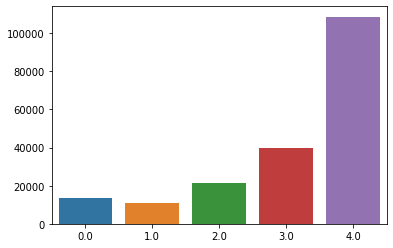

In [ ]:
"""
Let's take a quick look at the distribution of different ratings
"""
rating_frequency_count = data_df.overall.value_counts()
sns.barplot(x=rating_frequency_count.index, y=rating_frequency_count.values)

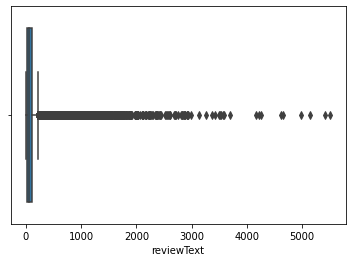

In [ ]:
"""
Now let's find out a value for maxlen. For that, we first look at the distribution of review lengths in terms of 
number of words. A box plot is used to visualize this distribution.
"""

re_wordMatcher = re.compile(r'[a-z0-9]+') #Declare regex to extract words
numWords = data_df["reviewText"].map(lambda x: len(re_wordMatcher.findall(x.lower())))
g = sns.boxplot(numWords)

In [ ]:
"""
The above plot shows that there are few very long reviews (black dots on the right) but most of the reviews are
comparatively shorter than around 250 words. Specifically, let's find the 90th quantile of the review length. 
"""

reviewLen90 = np.quantile(numWords, 0.90)
print("90th quantile of review length:", reviewLen90)

90th quantile of review length: 214.0


In [ ]:
"""
Thus, 90% of reviews are of 191 words or shorter. We'll set maxlen close to this.
"""
maxlen = 214

In [ ]:
"""
Lets's create training and test datasets by keeping ratio between the positive and negative labels same.
We use sklearn.model_selection.StratifiedKFold setting number of folds (n_splits) = 5, which splits the data into
80% train and 20% test and for 5 folds. But we keep only the first fold for this demo.
"""

skf = StratifiedKFold(n_splits=5)
for trn_idx, tst_idx in skf.split(data_df['reviewText'],data_df['overall']):
    break

train_df, test_df = data_df.iloc[trn_idx], data_df.iloc[tst_idx]

print("Shape of train and test dataframes:", train_df.shape, test_df.shape)

Shape of train and test dataframes: (155551, 2) (38888, 2)


In [ ]:
#Read FastText En model. If the file wiki.multi.en.vec' does not exist, download it from 
# https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
!pip install wget
import wget
word2VecFile = os.path.join(os.curdir, 'wiki.multi.en.vec')

if os.path.exists(word2VecFile):
    print('Word2Vec file has been found and is being loaded...')
else:    
    print('Word2Vec file does not exist and needs to be downloaded')
    url = 'https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec'
    wget.download(url)
    print('Downloading from', url)
en_model = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=66eb6d73f8e4e4b93848c8fde7b0c772b5b49d192f48fdbb6610350d071c1cd8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Word2Vec file does not exist and needs to be downloaded


In [ ]:
"""
Now let us create a numpy array containing the word vectors. Later this numpy array will be used for initilaizing 
the embedding layer in the model.
"""

vocab = list(en_model.vocab.keys())
print("Vocab size in pretrained model:", len(vocab))

# check if the word 'and' is present in the pretrained model
assert "and" in en_model

# check the dimension of the word vectors
assert embeddingDim == len(en_model["and"])

# initialize a numpy matrix which will store the word vectors
# first row is for the padding token
pretrained_weights = np.zeros((1+len(vocab), embeddingDim))

# tqdm just adds a progress bar
for i, token in enumerate(vocab):
    pretrained_weights[i, :] = en_model[token]

# map tokens in the vocab to ids
vocab = dict(zip(vocab, range(1, len(vocab)+1)))

Vocab size in pretrained model: 200000


In [ ]:
def reviewText2Features(reviewText):
    """
    Function which takes review text (basically a string!) as input and returns a features matrix X of shape
    (maxlen, embeddingDim). This is done by splitting the review into words and then representing each word by it's
    word vector obtained from the Word2Vec model. Sentences having more than maxlen words are truncated while shorter
    ones are zero-padded by pre-adding all zero vectors.
    """
    X = []
    
    reviewWords = re_wordMatcher.findall(reviewText.lower())
    
    """
    Tokenize the review using the word-matching regex and get its word vector from the pretrained Word2Vec model.
    Words not found in the Word2Vec model are ignored
    """
    for i, word in enumerate(reviewWords):
        if word not in en_model:
            continue
        if i >= maxlen:
            break
        # X.append(en_model[word])
        X.append(vocab[word])
    
    """
    Add zero padding in the begining of the sequence if the number of words is less than maxlen.
    """
    if len(X) < maxlen:
        # zero_padding = [[0.]*embeddingDim]*(maxlen - len(X))
        zero_padding = [0.]*(maxlen - len(X))
        X = zero_padding + X
    
    return X # np.array(X)
        
def row2Features(row):
    """
    Function which takes a datafram row as input and produces features and labels.
    
    Input: row | Type: pandas.core.series.Series
    
    Output: X, y | Type: X - np.ndarray of shape (maxlen, embeddingDim) & y - int where Positive = 0 & Negative = 1
    """    
    
    X = reviewText2Features(row["reviewText"])
    y = row["overall"]
        
    return X, y

In [ ]:
"""
Now apply the above function on a sample row
"""
sampleRow = data_df.iloc[0]
reviewWords = re_wordMatcher.findall(sampleRow["reviewText"].lower())
print("Review:", sampleRow["reviewText"])
print("Rating:", sampleRow["overall"])
print("Review words:", reviewWords)

Review: They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again
Rating: 3.0
Review words: ['they', 'look', 'good', 'and', 'stick', 'good', 'i', 'just', 'don', 't', 'like', 'the', 'rounded', 'shape', 'because', 'i', 'was', 'always', 'bumping', 'it', 'and', 'siri', 'kept', 'popping', 'up', 'and', 'it', 'was', 'irritating', 'i', 'just', 'won', 't', 'buy', 'a', 'product', 'like', 'this', 'again']


In [ ]:
"""
Give the sample row to the function row2Features
"""
X, y = row2Features(sampleRow)
print("Dimension of X:", len(X))
print("Label y:", y)

Dimension of X: 214
Label y: 3.0


In [ ]:
def shuffleArray(X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx, :]
    y = y[idx]
    return X, y

def generateModelReadyData(data, batchSize = 128, shuffle=False):
    """
    Generator function which generates features and labels in batches
    
    Input:
    data - DataFrame where each row has review and sentiment
    batchSize - No. of rows for which features will be created and returned in a batch.
    Note: This is useful for running mini-batch Gradient Descent optimization when the dataset is large.
    
    Output:
    X - 3D np.ndarray of shape (batchSize, maxlen, embeddingDim)
    y - 1D np. array of shape (batchSize,)        
    """
    
    while(True):
        X = []
        y = []
        for _, row in data.iterrows():
            """Generate features and label for this row"""
            X_, y_ = row2Features(row)

            """Keep accumulating the row-wise features"""
            X.append(X_)
            y.append(y_)   

            """If number of rows processed is greater than batchSize yield the batch and trim down X & y
            Note: This way we avoid running into memory issues by not bloating X and y bigger and bigger
            """
            if len(X) > batchSize:
                temp_X, temp_y = np.array(X[:batchSize]), np.array(y[:batchSize])
                if shuffle:
                    temp_X, temp_y = shuffleArray(temp_X, temp_y)
                
                X, y = X[batchSize:], y[batchSize:]                    
                yield temp_X, temp_y

        """Yield the remaining few rows when number of rows in data isn't a mutiple of batchSize"""
        if len(X) > 0:
            temp_X, temp_y = np.array(X), np.array(y)
            if shuffle:
                temp_X, temp_y = shuffleArray(temp_X, temp_y)
            
            yield temp_X, temp_y

In [ ]:
"""Let's test the generator function for few batches"""
numBatches = 0
for i, (X, y) in enumerate(generateModelReadyData(data_df, batchSize=128, shuffle=True)):
    if numBatches >= 3:
        break
    
    else:
        print("Batch:", i)
        assert X.shape == (128, maxlen)
        assert y.shape == (128,)
        print("Shape of X & y matches expected values")
    numBatches += 1

Batch: 0
Shape of X & y matches expected values
Batch: 1
Shape of X & y matches expected values
Batch: 2
Shape of X & y matches expected values


In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    print("cuda available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda available


In [ ]:
"""
Set random number seed using torch.manual_seed to make sure the same seed is used
by the Pytorch backend and hence ensure repeatable results
"""
#Seed 1
#torch.manual_seed(500)
#random.seed(400)
#np.random.seed(0)

#Seed 2
#torch.manual_seed(600)
#random.seed(450)
#np.random.seed(10)

#Seed 3
torch.manual_seed(700)
random.seed(500)
np.random.seed(20)

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, pretrained_weights):
        super(SentimentNet, self).__init__()
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        
        """
        Adding a dropout layer to force some of the feature values to zero.
        Note: Dropout is a regularization technique which sets the activation of few randomly chosen neurons of
        a hidden layer to zero. It can also be applied to the input layer where some of the input features are set to zero.
        For more details refer http://jmlr.org/papers/v15/srivastava14a.html
        """
        self.sentInputDropout = nn.Dropout(0.1)
        
        """
        Now let's stack a couple of bidirectional RNNs to process the input sequence and extract features
        """
        self.biLSTM1 = nn.LSTM(embedding_dim, hidden_dim[0], bidirectional=True, batch_first=True)
        self.biLSTMDropOut = nn.Dropout(0.1)
        self.dense1 = nn.Linear(2*hidden_dim[0], 50)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.outputLayer = nn.Linear(50, 5)

        
    def forward(self, x):
        
        batch_len = x.shape[0]
        out = self.embedding(x)
        out = self.sentInputDropout(out)
        out, hidden = self.biLSTM1(out)
        out = self.biLSTMDropOut(out)

        out = self.dense1(out)
        out = self.relu1(out)
        out = self.dropout2(out)
        out = self.outputLayer(out)
        out = out[:,-1]
        return out    

In [ ]:
model = SentimentNet(embeddingDim, [100], 1+len(vocab), pretrained_weights)
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=5, bias=True)
)

In [ ]:
lr=0.7
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

In [ ]:
epochs = 10
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf
gamma=0.9

model = model.float()
model.train()
for i in range(epochs):
    print("Epoch:", i+1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma-(0.001/((epochs+1)-i)))
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    print("Running a pass over the training data...")
    for j, (inputs, labels) in enumerate(generateModelReadyData(train_df, batchSize=128, shuffle=True)):
        if j >= np.ceil(train_df.shape[0]/128):
            break
        
    #for inputs, labels in train_loader:
        counter += 1
        inputs, labels = torch.from_numpy(inputs), torch.from_numpy(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs.long())
       
        loss = criterion(output, labels.type(torch.LongTensor).to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        if (j+1) % 100 == 0:
            print("Batches completed:", j+1)
    
    print("Batches completed:", j+1)
    val_losses = []
    model.eval()
    print("Running a pass over the test data...")
    for k, (inp, lab) in enumerate(generateModelReadyData(test_df, batchSize=128, shuffle=False)):
        if k >= np.ceil(test_df.shape[0]/128):
            break
        inp, lab = torch.from_numpy(inp), torch.from_numpy(lab)
        inp, lab = inp.to(device), lab.to(device)
        out = model(inp.long())
        val_loss = criterion(out.squeeze(), lab.type(torch.LongTensor).to(device))
        val_losses.append(val_loss.item())
        if (k+1) % 100 == 0:
            print("Batches completed:", k+1)
    
    print("Batches completed:", k+1)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1
0.6299363636363636
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 400
Batches completed: 500
Batches completed: 600
Batches completed: 700
Batches completed: 800
Batches completed: 900
Batches completed: 1000
Batches completed: 1100
Batches completed: 1200
Batches completed: 1217
Running a pass over the test data...
Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 305
Epoch: 1/10... Step: 1216... Loss: 0.328783... Val Loss: 1.472584
Validation loss decreased (inf --> 1.472584).  Saving model ...
Epoch: 2
0.5668797336363637
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 400
Batches completed: 500
Batches completed: 600
Batches completed: 700
Batches completed: 800
Batches completed: 900
Batches completed: 1000
Batches completed: 1100
Batches completed: 1200
Batches completed: 12

In [ ]:
"""
At this point we can load a pretrained model which was trained for 5 epochs and make predictions using it.
Uncomment and run the below line to load the pretrained model
"""
model.load_state_dict(torch.load('./state_dict.pt'))
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=5, bias=True)
)

In [ ]:
test_losses = []
num_correct = 0
pred_proba = []
actual = []

model.eval()
for j, (X_test, y_test) in enumerate(generateModelReadyData(test_df, batchSize=128)):
    if j >= np.ceil(test_df.shape[0]/128):
        break
    
    inputs_test, labels_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output_test = model(inputs_test.long())
    test_loss = criterion(output_test.squeeze(), labels_test.type(torch.LongTensor).to(device))
    test_losses.append(test_loss.item())
    _, predicted = torch.max(output_test, 1) 
    correct_tensor = predicted.eq(labels_test.long())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_proba.extend(output_test.cpu().squeeze().detach().numpy())
    actual.extend(y_test)
    
    if (j+1) % 100 == 0:
        print("Batches completed:", j+1)

print("Batches completed:", j+1)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_df)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 305
Test loss: 1.379
Test accuracy: 55.886%
